# WGAN and SN-GAN : Seminar

In [136]:
import torch
import torchvision
s
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data

In [137]:
class Distribution:
    
    
    """
    
    Abstract class for density (real or fake)
    
    """
    
    def log_density(self, x):
        
        """
        
        x :     torch.tensor of shape B x D
        returns torch.tensor of shape B
        
        """
        raise NotImplementedError
        
        
    def sample(self, sample_count):
        
        """
        sample_count  int
        
        """
        raise NotImplementedError

In [138]:
class MultivariateNormal(Distribution):
    
    """
    
    Class for Multivariate Normal density with Isotropic covariance matrix
    
    """
    
    def __init__(self, loc, scale):
        
        """
        loc   torch.tensor of shape D
        scale torch.tensor of shape D x D
        
        """
        
        super().__init__()
        self.loc = loc
        self.scale = scale
        
        self.distribution = torch.distributions.MultivariateNormal(loc = loc, covariance_matrix = scale)
         
            
    def log_density(self, x):
        
        """
        x        torch.tensor of shape B x D
        returns: torch.tensor of shape B
        
        """
        
  
        return self.distribution.log_prob(x.clone())
    
    def sample(self, sample_count):
        
        """
        sample_count int
        returns      torch.tensor of shape  sample_count x D
        
        """
        
        return self.distribution.rsample( torch.Size([sample_count]) )

In [139]:
class MixtureNormal(Distribution):
    
    """
    
    Class for mixture of multivariate normal distribution
    
    """
    
    def __init__(self, locs, scales , pi):
        
        """
        
        Define mixture of multivariate normals through MultivariateNormal
        
        """
        
        super().__init__()
        
        self.locs = locs
        self.scales = scales
        self.pi = pi
        
        
        self.dists = [MultivariateNormal(loc, scale ) for loc, scale in zip(locs, scales)]
        
        
    def log_density(self, x):
        
        """
        
        """
        
        raise NotImplementedError
        
        
        
    def sample(self, sample_count):
        
        """
        
        sample_count int
        return       torch.tensor of shape sample_count x D
        
        """
        
        samples_1 = self.dists[0].sample(sample_count//2)
        samples_2 = self.dists[1].sample(sample_count//2)
        return torch.cat([samples_1,samples_2], dim = 0)
        

In [140]:
SAMPLES_COUNT = 1000

loc_uni = 3*torch.ones(2)
cov_uni = torch.eye(2)

loc_bi = [torch.zeros(2), 6 * torch.ones(2)]
cov_bi = [torch.eye(2), torch.eye(2)]
pi = [0.5,0.5]

fake_distribution = MultivariateNormal(loc_uni, cov_uni)
fake_samples  = fake_distribution.sample(SAMPLES_COUNT)


true_distribution = MixtureNormal(loc_bi, cov_bi,pi)
true_samples = true_distribution.sample(SAMPLES_COUNT)

In [141]:
def visualize_2d_data(data , label):
    
    """
    
    """
    
    fig,ax = plt.subplots(figsize=(16,3))
    ax.scatter(data[0][:,0],data[0][:,1], s = 10, label = label[0])
    ax.scatter(data[1][:,0],data[1][:,1], s = 10, label = label[1])
    plt.legend()
    plt.show()

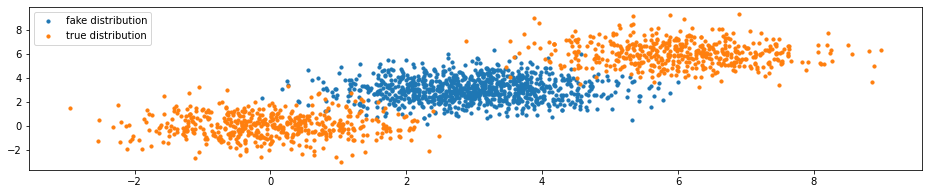

In [142]:
visualize_2d_data([fake_samples,true_samples], label=['fake distribution','true distribution'])


In [163]:
a = torch.tensor([1,2,3,4])
a.clamp_(min=1,max=2)

tensor([1, 2, 2, 2])

## 2. WGAN

In [167]:
class Clipper(torch.nn.Module):
    
    """
    
    
    """
    
    def __init__(self , module , bound ,  name = 'weight'):
        
        """
        
        Initialization
        
        bound : int (bound of Compact set)
        
        """
        super().__init__()
        self.module = module
        self.bound =  bound
        self.name  =  name
        
    def clipping(self):
        
        """
        
        
        """
        
    
        
        self.module._parameters[self.name].data.clamp_( min = -self.bound , max = self.bound)

        
        
    def forward(self, x):
        
        """
        
        """
        
        self.clipping() 
        return self.module.forward(x)
        

In [168]:
def train( 
    critic, 
    critic_optimizer,
    real_loader,
    fake_loader, 
    batch_size,
    n_epochs
):
    
    
    """
    
    critic           : torch.nn.Sequential model (feedforwardnetwork)
    critic_optimizer : torch.optim
    real_loader      : torch.utils.data.DataLoader
    fake_loader.     : torch.utils.data.DataLoader
    batch_size.      : int
    n_epochs         : int
    
    
    """
    
    
    train_losses = []

    critic.train()
 

    curr_iter = 0
    
    for epoch_i in range(n_epochs):
        
      

        for  real_data, fake_data in  zip(real_loader, fake_loader):
            
            curr_iter += 1
            real_data = real_data.clone().detach().float()
            real_data = 2 * (real_data - 0.5)  ### ???

            
            # do a critic update
            critic_optimizer.zero_grad()
            
           
            
           
            d_loss =  critic(fake_data).mean() - critic(real_data).mean()  
            d_loss.backward()
            
            critic_optimizer.step()
       
        train_losses.append(d_loss.detach().item())

 
    return np.array(train_losses)

In [169]:
class Critic(torch.nn.Module):
    
    def __init__(self, dim, bound):
        
        
        """
        
        """
        
        super().__init__()
        
        self.dim = dim
         
        model = []
        
        for num in range(1, len(dim)):
            
            model.append( Clipper(torch.nn.Linear(dim[num - 1], dim[num] ) , bound) )
            model.append(torch.nn.ReLU())
            
        model.pop()
        
        self.net = torch.nn.Sequential(*model)
        
    def forward(self, x):
        
        return self.net(x)

In [215]:
DIM = [2,50,50,1]
DEVICE = 'cpu'
BOUND = 0.1

critic = Critic(DIM,BOUND).to(DEVICE)

In [216]:
real_data = true_samples
fake_data = fake_samples
 
BATCH_SIZE = 64
real_loader = torch.utils.data.DataLoader(real_data, batch_size=BATCH_SIZE, shuffle = True)
fake_loader = torch.utils.data.DataLoader(fake_data, batch_size=BATCH_SIZE, shuffle = True)

In [217]:
N_EPOCHS = 500
 

critic_optimizer = torch.optim.Adam(critic.parameters(), lr=2e-4, betas=(0, 0.9))

losses = train( 
    critic, 
    critic_optimizer,
    real_loader,
    fake_loader,
    BATCH_SIZE, 
    N_EPOCHS
)

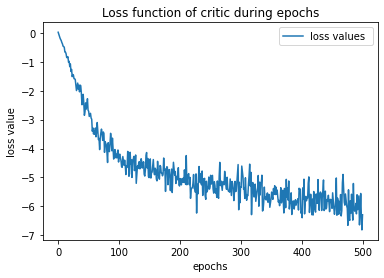

In [218]:
plt.title("Loss function of critic during epochs")
plt.plot(losses,label='loss values ');
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()
plt.show()

In [176]:
N = 1000
xlist = np.linspace(-4,16,N)
ylist = np.linspace(-4,10,N)
Xm,Ym = np.meshgrid(xlist,ylist)
Z  = np.concatenate([Xm.reshape(-1,1),Ym.reshape(-1,1)],axis=1)
Z = torch.tensor(Z,dtype = torch.float32)
Z = critic(Z).detach().numpy().reshape(N,N)

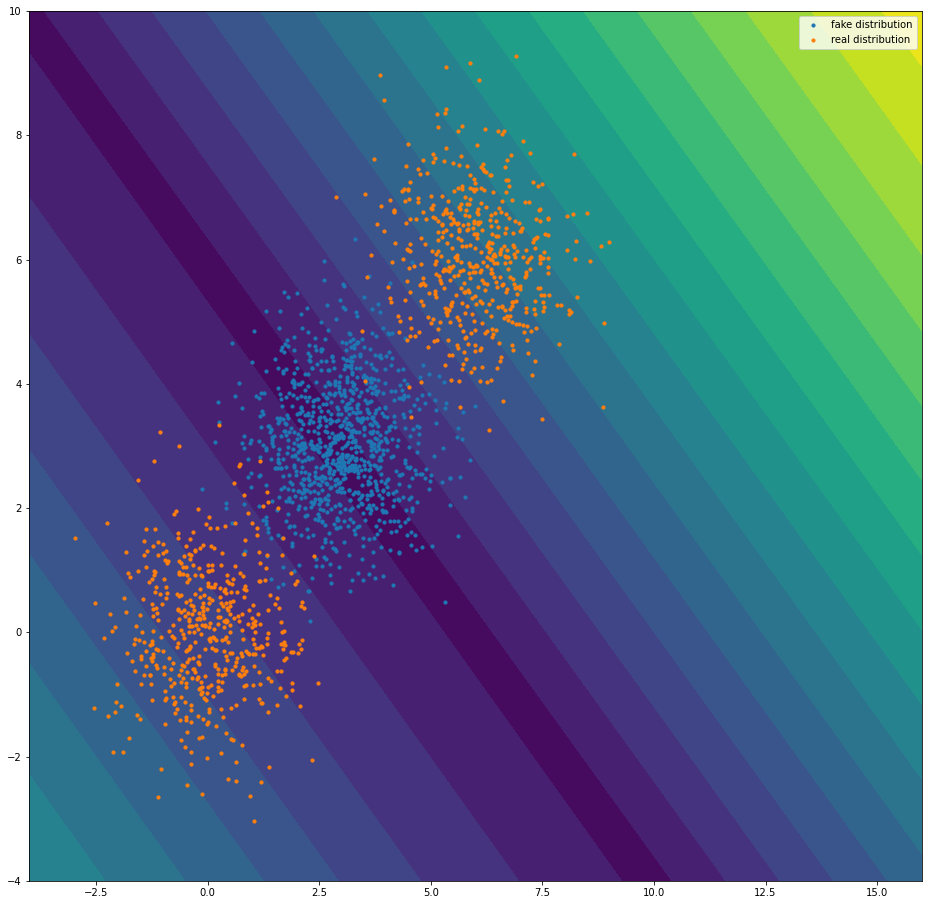

In [151]:
fig,ax = plt.subplots(figsize=(16,16))
ax.contourf(Xm,Ym,Z,levels=20)
ax.scatter(fake_data[:,0].detach(),fake_data[:,1].detach(), s = 10, label = 'fake distribution')
ax.scatter(real_data[:,0].detach(),real_data[:,1].detach(), s=10, label = 'real distribution')
plt.legend()
plt.show();

# 3. SN-GAN

In [152]:
def l2normalize(v,eps=1e-15):
    
    """
    
    """
    return v / (torch.norm(v) + eps)

In [226]:
w = torch.tensor([[1,2,5],[3,4,6]])
w.new(3)

tensor([-2305843009213693952, -2305843009213693952, -9223372036854775800])

In [219]:
class Spectralnorm(torch.nn.Module):
    
    
    def __init__(self, module,
                 name = 'weight',
                 power_iterations = 1):
        
        
        """
        
        Initialization
        
        """
        
        super().__init__()
        
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        
        
        if not self._made_params():
            self._make_params()
        
        
    def _update_u_v(self):
        
        
        """
        
        Power Iteration method
        
        """
        
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")
        
        height = w.data.shape[0] # C_out
        
        
        
        
        
        
        for iteration in range(self.power_iterations):
            #torch.mv #torch.mm #torch.norm
           
             
        
        
        
    def _made_params(self):
        
        """
        
        
        """
        
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False
        
        
        
        
    def _make_params(self):
        
        """
        
        
        """
        
        w = getattr(self.module , self.name)
        height = w.data.shape[0] # c_out
        width  = w.data.shape[-1] # c_in
        
        
        # create random vectors for power iteration method
        
        u = torch.nn.Parameter(w.data.new(height).normal_(0,1), requires_grad  = False)
        v = torch.nn.Parameter(w.data.new(width).normal_(0,1),  requires_grad  =  False)
        w_bar = torch.nn.Parameter(w.data, requires_grad = True)
        
        
        
        # normalization
        
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        
        
        del self.module._parameters[self.name]
        
        self.module.register_parameter(self.name + "_u", u)  
        self.module.register_parameter(self.name + "_v", v)  
        self.module.register_parameter(self.name + "_bar", w_bar) # requires grad
        
        
        
        
    def forward(self, *args):
        
        """
        
        """
        self._update_u_v()
        return self.module.forward(*args)
        

In [227]:
def train( 
    critic, 
    critic_optimizer,
    real_loader,
    fake_loader, 
    batch_size,
    n_epochs
):
    
    
    """
    
    critic           : torch.nn.Sequential model (feedforwardnetwork)
    critic_optimizer : torch.optim
    real_loader      : torch.utils.data.DataLoader
    fake_loader.     : torch.utils.data.DataLoader
    batch_size.      : int
    n_epochs         : int
    
    
    """
    
    
    train_losses = []

    critic.train()
 

    curr_iter = 0
    
    for epoch_i in range(n_epochs):
        
      

        for  real_data, fake_data in  zip(real_loader, fake_loader):
            
            curr_iter += 1
            real_data = real_data.clone().detach().float()
            real_data = 2 * (real_data - 0.5)  ### ???

            
            # do a critic update
            critic_optimizer.zero_grad()
            
           
            
           
            d_loss =  critic(fake_data).mean() - critic(real_data).mean()  
            d_loss.backward()
            
            critic_optimizer.step()
       
        train_losses.append(d_loss.detach().item())

 
    return np.array(train_losses)

In [228]:
class Critic(torch.nn.Module):
    
    def __init__(self, dim):
        
        
        """
        
        """
        
        super().__init__()
        
        self.dim = dim
         
        model = []
        
        for num in range(1, len(dim)):
            
            model.append(Spectralnorm(torch.nn.Linear(dim[num - 1], dim[num] ) ))
            model.append(torch.nn.ReLU())
            
        model.pop()
        
        self.net = torch.nn.Sequential(*model)
        
    def forward(self, x):
        
        return self.net(x)

In [229]:
DIM = [2,50,50,1]
DEVICE = 'cpu'


critic = Critic(DIM).to(DEVICE)

In [230]:
real_data = true_samples
fake_data = fake_samples
 
BATCH_SIZE = 64
real_loader = torch.utils.data.DataLoader(real_data, batch_size=BATCH_SIZE, shuffle = True)
fake_loader = torch.utils.data.DataLoader(fake_data, batch_size=BATCH_SIZE, shuffle = True)

In [231]:
N_EPOCHS = 500
 

critic_optimizer = torch.optim.Adam(critic.parameters(), lr=2e-4, betas=(0, 0.9))

losses = train( 
    critic, 
    critic_optimizer,
    real_loader,
    fake_loader,
    BATCH_SIZE, 
    N_EPOCHS
)

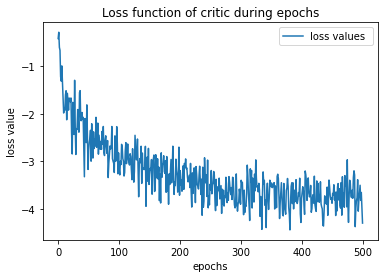

In [232]:
plt.title("Loss function of critic during epochs")
plt.plot(losses,label='loss values ');
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()
plt.show()

In [161]:
N = 1000
xlist = np.linspace(-4,16,N)
ylist = np.linspace(-4,10,N)
Xm,Ym = np.meshgrid(xlist,ylist)
Z  = np.concatenate([Xm.reshape(-1,1),Ym.reshape(-1,1)],axis=1)
Z = torch.tensor(Z,dtype = torch.float32)
Z = critic(Z).detach().numpy().reshape(N,N)

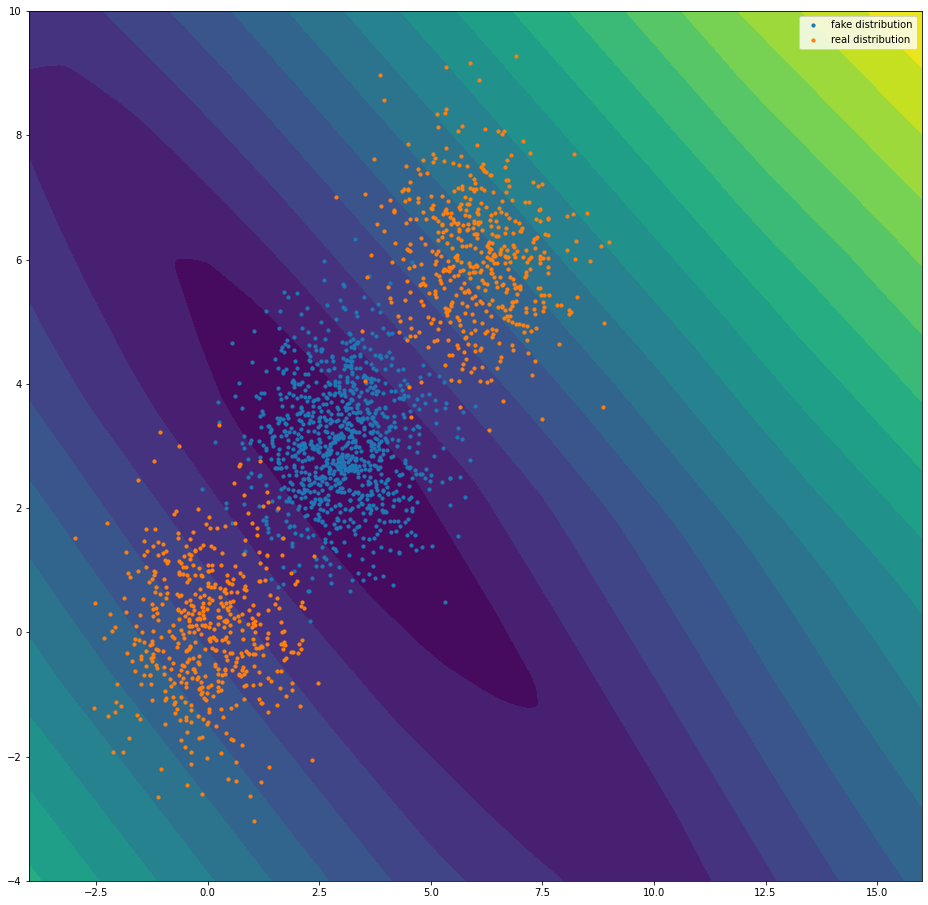

In [162]:
fig,ax = plt.subplots(figsize=(16,16))
ax.contourf(Xm,Ym,Z,levels=20)
ax.scatter(fake_data[:,0].detach(),fake_data[:,1].detach(), s = 10, label = 'fake distribution')
ax.scatter(real_data[:,0].detach(),real_data[:,1].detach(), s=10, label = 'real distribution')
plt.legend()
plt.show();